# 分类模型的loss函数，MSE和NLL(等价于交叉熵)

## p2. 回顾

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
data_path = "../../myData/p1ch7/cifar"

In [3]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [4]:
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

In [5]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

In [6]:
len(cifar10), len(cifar10_val)

(50000, 10000)

In [7]:
type(cifar10)

torchvision.datasets.cifar.CIFAR10

In [8]:
# 只需要飞机和鸟两类，对标签进行重新映射，从0和2映射到0和1
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]

In [9]:
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]
# 同时需要注意，cifar10是datasets类，而cifar2是list类
len(cifar2), len(cifar2_val)

(10000, 2000)

In [10]:
output_size = 2

In [11]:
cifar2[0][0].shape

torch.Size([3, 32, 32])

In [12]:
input_size = 3 * 32 * 32

In [13]:
hidden_size = 256

In [14]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size), nn.Tanh(), nn.Linear(hidden_size, output_size)
)

model

Sequential(
  (0): Linear(in_features=3072, out_features=256, bias=True)
  (1): Tanh()
  (2): Linear(in_features=256, out_features=2, bias=True)
)

In [15]:
test_img = cifar2[0][0].view(-1)
test_batch = cifar2[0][0].view(-1).unsqueeze(0)
test_img.shape, test_batch.shape

(torch.Size([3072]), torch.Size([1, 3072]))

可以看到，输出的尺寸与输入的尺寸相关，而一般我们都是以batch为单位输入的，所以网络最后的nn.Softmax()层的dim为1，而非0。

In [16]:
model(test_img).shape, model(test_batch).shape

(torch.Size([2]), torch.Size([1, 2]))

In [17]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [18]:
x = torch.tensor([-10, -300, 20, 50])
softmax(x)

tensor([8.7565e-27, 0.0000e+00, 9.3576e-14, 1.0000e+00])

In [19]:
x = torch.tensor([1, 3, 4, 2, 5])
softmax(x)

tensor([0.0117, 0.0861, 0.2341, 0.0317, 0.6364])

In [20]:
softmax = nn.Softmax(dim=1)

In [21]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, output_size),
    nn.Softmax(dim=1),
)

model

Sequential(
  (0): Linear(in_features=3072, out_features=256, bias=True)
  (1): Tanh()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


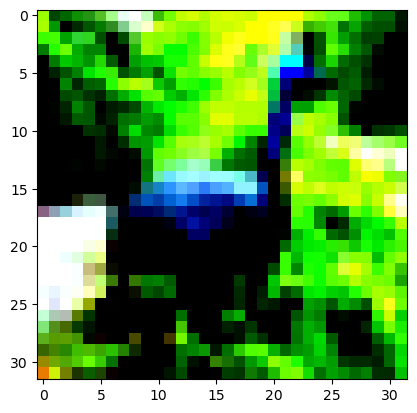

In [22]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [23]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [24]:
out = model(img_batch)
out

tensor([[0.5012, 0.4988]], grad_fn=<SoftmaxBackward0>)

In [25]:
_, index = torch.max(out, dim=1)
index

tensor([0])

max()这类方法的dim参数，一般返回结果都会被消除，例如，如果是个(2,3,4)的张量t，dim=1，就是每个t[:,i,:]各自内部执行max()，再将所有的结果根据剩余的维度返回，所以第二维3就被消除了，

In [26]:
test = torch.tensor(list(range(2 * 3 * 4)))
test = test[torch.randperm(test.size(0))].view(2, 3, 4)

In [27]:
m, index = torch.max(test, dim=1)
test, m, m.shape

(tensor([[[15,  7, 17,  3],
          [23, 19, 22,  5],
          [ 6,  4, 18,  1]],
 
         [[ 8,  0,  2, 14],
          [13, 21, 12, 10],
          [ 9, 20, 11, 16]]]),
 tensor([[23, 19, 22,  5],
         [13, 21, 12, 16]]),
 torch.Size([2, 4]))

In [28]:
test[0, :, 0]

tensor([15, 23,  6])

## p3. 

In [29]:
out = torch.tensor(
    [
        [0.6, 0.4],
        [0.9, 0.1],
        [0.3, 0.7],
        [0.2, 0.8],
    ]
)

In [30]:
_, index = torch.max(out, dim=1)
index

tensor([0, 0, 1, 1])

In [31]:
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)
truth = torch.zeros(4, 2)
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [32]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()

In [33]:
mse(out)

tensor(0.1500)

In [34]:
temp = out.gather(dim=1, index=class_index)
temp

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [35]:
temp_target = torch.zeros(4, 2)
temp_target.scatter_(dim=1, index=class_index, src=temp)
temp_target

tensor([[0.6000, 0.0000],
        [0.9000, 0.0000],
        [0.0000, 0.7000],
        [0.0000, 0.8000]])

In [36]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod


likelihood(out)

tensor([0.3024])

In [37]:
def neg_log_likelihood(out):
    return -likelihood(out).log()


neg_log_likelihood(out)

tensor([1.1960])

# p4. 分类模型的loss和激活层的配对，网络的训练

In [38]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

In [39]:
softmax(x), torch.log(softmax(x))

(tensor([[0., 1.]]), tensor([[-inf, 0.]]))

In [40]:
log_softmax(x)

tensor([[-104.,    0.]])

In [41]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, output_size),
    nn.LogSoftmax(dim=1),
)
loss_fn = nn.NLLLoss()

In [42]:
img, label = cifar2[0]
print(label)
out = model(img.view(-1).unsqueeze(0))
loss_fn(out, torch.tensor([label]))  # NLLLoss不需要one-hot编码

1


tensor(0.6670, grad_fn=<NllLossBackward0>)

In [43]:
input_size, hidden_size, output_size

(3072, 256, 2)

In [44]:
type(cifar2)

list

In [91]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_x, train_y, val_x, val_y):
    for epoch in range(1, n_epochs + 1):
        output = model(train_x)
        loss = loss_fn(output, train_y)

        with torch.no_grad():
            val_output = model(val_x)
            val_loss = loss_fn(val_output, val_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch: {epoch}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")

In [47]:
train_data = torch.stack([img.view(-1) for img, _ in cifar2], dim=0)
# train_label = torch.stack([torch.tensor([label]) for _, label in cifar2])
train_label = torch.stack([torch.tensor(label) for _, label in cifar2])
train_data.shape, train_label.shape

(torch.Size([10000, 3072]), torch.Size([10000]))

In [49]:
val_data = torch.stack([img.view(-1) for img, _ in cifar2_val], dim=0)
val_label = torch.stack([torch.tensor(label) for _, label in cifar2_val])
val_data.shape, val_label.shape

(torch.Size([2000, 3072]), torch.Size([2000]))

In [85]:
lr = 1e-2
optimizer = optim.SGD(model.parameters(), lr=lr)
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, output_size),
    nn.LogSoftmax(dim=1),
)
loss_fn = nn.NLLLoss()

In [86]:
n_acc = 0
for i in range(len(cifar2_val)):
    img, label = cifar2_val[i]
    pred = model(img.view(-1).unsqueeze(0)).argmax()
    if label == pred:
        n_acc += 1
    else:
        print(
            f"index: {i}, prediction: {class_names[pred]}, label: {class_names[label]}"
        )
print(f"accuracy: {n_acc / len(cifar2_val)}")

index: 0, prediction: bird, label: airplane
index: 1, prediction: bird, label: airplane
index: 2, prediction: bird, label: airplane
index: 4, prediction: bird, label: airplane
index: 5, prediction: airplane, label: bird
index: 11, prediction: bird, label: airplane
index: 14, prediction: airplane, label: bird
index: 16, prediction: bird, label: airplane
index: 18, prediction: bird, label: airplane
index: 19, prediction: airplane, label: bird
index: 20, prediction: bird, label: airplane
index: 21, prediction: airplane, label: bird
index: 23, prediction: bird, label: airplane
index: 26, prediction: airplane, label: bird
index: 27, prediction: airplane, label: bird
index: 28, prediction: airplane, label: bird
index: 33, prediction: bird, label: airplane
index: 34, prediction: bird, label: airplane
index: 35, prediction: bird, label: airplane
index: 38, prediction: bird, label: airplane
index: 39, prediction: bird, label: airplane
index: 40, prediction: airplane, label: bird
index: 41, pred

In [92]:
training_loop(
    n_epochs=5,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_x=train_data,
    train_y=train_label,
    val_x=val_data,
    val_y=val_label,
)

Epoch: 1, Loss: 0.7333, Val Loss: 0.7338
Epoch: 2, Loss: 0.7333, Val Loss: 0.7338
Epoch: 3, Loss: 0.7333, Val Loss: 0.7338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: bird, label: airplane


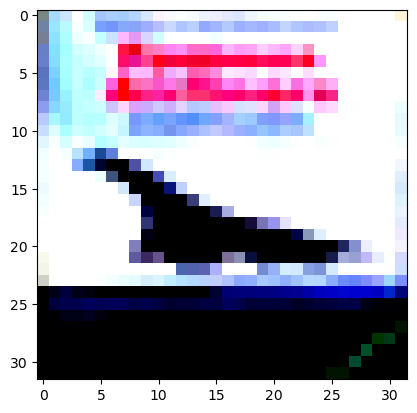

In [90]:
img, label = cifar2_val[0]
pred = model(img.view(-1).unsqueeze(0)).argmax()
print(f"prediction: {class_names[pred]}, label: {class_names[label]}")
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [94]:
n_acc = 0
for i in range(len(cifar2_val)):
    img, label = cifar2_val[i]
    pred = model(img.view(-1).unsqueeze(0)).argmax()
    if label == pred:
        n_acc += 1
    else:
        print(
            f"index: {i}, prediction: {class_names[pred]}, label: {class_names[label]}"
        )
        # plt.imshow(img.permute(1, 2, 0))
        # plt.show()
print(f"accuracy: {n_acc / len(cifar2_val)}")

index: 0, prediction: bird, label: airplane
index: 1, prediction: bird, label: airplane
index: 2, prediction: bird, label: airplane
index: 4, prediction: bird, label: airplane
index: 5, prediction: airplane, label: bird
index: 11, prediction: bird, label: airplane
index: 14, prediction: airplane, label: bird
index: 16, prediction: bird, label: airplane
index: 18, prediction: bird, label: airplane
index: 19, prediction: airplane, label: bird
index: 20, prediction: bird, label: airplane
index: 21, prediction: airplane, label: bird
index: 23, prediction: bird, label: airplane
index: 26, prediction: airplane, label: bird
index: 27, prediction: airplane, label: bird
index: 28, prediction: airplane, label: bird
index: 33, prediction: bird, label: airplane
index: 34, prediction: bird, label: airplane
index: 35, prediction: bird, label: airplane
index: 38, prediction: bird, label: airplane
index: 39, prediction: bird, label: airplane
index: 40, prediction: airplane, label: bird
index: 41, pred

**可以看到，acc没有任何变化，所以训练失败**

### 因为需要使用DataLoader

In [95]:
from torch.utils.data import DataLoader

In [109]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

In [108]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        for imgs, labels in train_loader:
            train_pred = model(imgs.view(imgs.shape[0], -1))
            train_loss = loss_fn(train_pred, labels)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}, Loss: {train_loss:.4f}")

In [110]:
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, output_size),
    nn.LogSoftmax(dim=1),
)
lr = 1e-2
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.NLLLoss()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

Epoch: 1, Loss: 0.4152
Epoch: 2, Loss: 0.5557
Epoch: 3, Loss: 0.4037
Epoch: 4, Loss: 0.2490
Epoch: 5, Loss: 0.2308
Epoch: 6, Loss: 0.4427
Epoch: 7, Loss: 0.4255
Epoch: 8, Loss: 0.2796
Epoch: 9, Loss: 0.3661
Epoch: 10, Loss: 0.4022
Epoch: 11, Loss: 0.3298
Epoch: 12, Loss: 0.4007
Epoch: 13, Loss: 0.2864
Epoch: 14, Loss: 0.4074
Epoch: 15, Loss: 0.4429
Epoch: 16, Loss: 0.2229
Epoch: 17, Loss: 0.0930
Epoch: 18, Loss: 0.2626
Epoch: 19, Loss: 0.4484
Epoch: 20, Loss: 0.2932
Epoch: 21, Loss: 0.2700
Epoch: 22, Loss: 0.2493
Epoch: 23, Loss: 0.2878
Epoch: 24, Loss: 0.2910
Epoch: 25, Loss: 0.1886
Epoch: 26, Loss: 0.1592
Epoch: 27, Loss: 0.3047
Epoch: 28, Loss: 0.1512
Epoch: 29, Loss: 0.2554
Epoch: 30, Loss: 0.3370
Epoch: 31, Loss: 0.2456
Epoch: 32, Loss: 0.1224
Epoch: 33, Loss: 0.0895
Epoch: 34, Loss: 0.1257
Epoch: 35, Loss: 0.2995
Epoch: 36, Loss: 0.1024
Epoch: 37, Loss: 0.2452
Epoch: 38, Loss: 0.1404
Epoch: 39, Loss: 0.1885
Epoch: 40, Loss: 0.1016
Epoch: 41, Loss: 0.0824
Epoch: 42, Loss: 0.4323
E

In [111]:
# 测试集准确率
n_acc = 0
for i in range(len(cifar2_val)):
    img, label = cifar2_val[i]
    pred = model(img.view(-1).unsqueeze(0)).argmax()
    if label == pred:
        n_acc += 1
    else:
        print(
            f"index: {i}, prediction: {class_names[pred]}, label: {class_names[label]}"
        )
        # plt.imshow(img.permute(1, 2, 0))
        # plt.show()
print(f"accuracy: {n_acc / len(cifar2_val)}")

index: 4, prediction: bird, label: airplane
index: 7, prediction: bird, label: airplane
index: 13, prediction: airplane, label: bird
index: 14, prediction: airplane, label: bird
index: 23, prediction: bird, label: airplane
index: 24, prediction: airplane, label: bird
index: 25, prediction: airplane, label: bird
index: 27, prediction: airplane, label: bird
index: 31, prediction: airplane, label: bird
index: 32, prediction: airplane, label: bird
index: 36, prediction: airplane, label: bird
index: 38, prediction: bird, label: airplane
index: 39, prediction: bird, label: airplane
index: 40, prediction: airplane, label: bird
index: 45, prediction: bird, label: airplane
index: 53, prediction: airplane, label: bird
index: 57, prediction: bird, label: airplane
index: 62, prediction: bird, label: airplane
index: 63, prediction: airplane, label: bird
index: 69, prediction: airplane, label: bird
index: 78, prediction: bird, label: airplane
index: 83, prediction: airplane, label: bird
index: 89, p

In [113]:
# 训练集准确率, 也可以使用dataloader
n_acc = 0
for i in range(len(cifar2)):
    img, label = cifar2[i]
    with torch.no_grad():
        pred = model(img.view(-1).unsqueeze(0)).argmax()
    if label == pred:
        n_acc += 1
    else:
        print(
            f"index: {i}, prediction: {class_names[pred]}, label: {class_names[label]}"
        )
        # plt.imshow(img.permute(1, 2, 0))
        # plt.show()
print(f"accuracy: {n_acc / len(cifar2)}")

index: 359, prediction: airplane, label: bird
index: 1099, prediction: airplane, label: bird
index: 1541, prediction: airplane, label: bird
index: 2359, prediction: airplane, label: bird
index: 3032, prediction: airplane, label: bird
index: 6726, prediction: bird, label: airplane
index: 7489, prediction: airplane, label: bird
index: 8316, prediction: airplane, label: bird
index: 8340, prediction: bird, label: airplane
index: 8779, prediction: airplane, label: bird
index: 9338, prediction: airplane, label: bird
index: 9618, prediction: bird, label: airplane
accuracy: 0.9988


增加网络层数，提高分类效果

In [117]:
deep_model = nn.Sequential(
    nn.Linear(input_size, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)
loss_fn = nn.CrossEntropyLoss()
lr = 1e-2
optimizer = optim.SGD(deep_model.parameters(), lr=lr)
n_epochs = 100

In [118]:
training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=deep_model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

Epoch: 1, Loss: 0.5352
Epoch: 2, Loss: 0.2960
Epoch: 3, Loss: 0.3979
Epoch: 4, Loss: 0.6728
Epoch: 5, Loss: 0.4015
Epoch: 6, Loss: 0.3415
Epoch: 7, Loss: 0.5239
Epoch: 8, Loss: 0.5855
Epoch: 9, Loss: 0.2707
Epoch: 10, Loss: 0.3927
Epoch: 11, Loss: 0.5184
Epoch: 12, Loss: 0.3318
Epoch: 13, Loss: 0.5127
Epoch: 14, Loss: 0.2662
Epoch: 15, Loss: 0.2661
Epoch: 16, Loss: 0.3102
Epoch: 17, Loss: 0.5137
Epoch: 18, Loss: 0.3348
Epoch: 19, Loss: 0.2775
Epoch: 20, Loss: 0.3187
Epoch: 21, Loss: 0.1719
Epoch: 22, Loss: 0.1952
Epoch: 23, Loss: 0.2582
Epoch: 24, Loss: 0.7041
Epoch: 25, Loss: 0.3208
Epoch: 26, Loss: 0.3756
Epoch: 27, Loss: 0.3561
Epoch: 28, Loss: 0.1138
Epoch: 29, Loss: 0.1302
Epoch: 30, Loss: 0.5164
Epoch: 31, Loss: 0.0969
Epoch: 32, Loss: 0.2110
Epoch: 33, Loss: 0.0317
Epoch: 34, Loss: 0.2707
Epoch: 35, Loss: 0.0867
Epoch: 36, Loss: 0.1667
Epoch: 37, Loss: 0.1318
Epoch: 38, Loss: 0.3526
Epoch: 39, Loss: 0.1403
Epoch: 40, Loss: 0.0397
Epoch: 41, Loss: 0.2343
Epoch: 42, Loss: 0.1256
E

In [120]:
# 训练集准确率, 也可以使用dataloader
n_acc = 0
for i in range(len(cifar2)):
    img, label = cifar2[i]
    with torch.no_grad():
        pred = deep_model(img.view(-1).unsqueeze(0)).argmax()
    if label == pred:
        n_acc += 1
    else:
        print(
            f"index: {i}, prediction: {class_names[pred]}, label: {class_names[label]}"
        )
        # plt.imshow(img.permute(1, 2, 0))
        # plt.show()
print(f"accuracy: {n_acc / len(cifar2)}")

accuracy: 1.0


In [119]:
# 测试集准确率
n_acc = 0
for i in range(len(cifar2_val)):
    img, label = cifar2_val[i]
    pred = deep_model(img.view(-1).unsqueeze(0)).argmax()
    if label == pred:
        n_acc += 1
    else:
        print(
            f"index: {i}, prediction: {class_names[pred]}, label: {class_names[label]}"
        )
        # plt.imshow(img.permute(1, 2, 0))
        # plt.show()
print(f"accuracy: {n_acc / len(cifar2_val)}")

index: 7, prediction: bird, label: airplane
index: 13, prediction: airplane, label: bird
index: 14, prediction: airplane, label: bird
index: 18, prediction: bird, label: airplane
index: 23, prediction: bird, label: airplane
index: 24, prediction: airplane, label: bird
index: 25, prediction: airplane, label: bird
index: 27, prediction: airplane, label: bird
index: 32, prediction: airplane, label: bird
index: 36, prediction: airplane, label: bird
index: 37, prediction: airplane, label: bird
index: 39, prediction: bird, label: airplane
index: 53, prediction: airplane, label: bird
index: 57, prediction: bird, label: airplane
index: 69, prediction: airplane, label: bird
index: 78, prediction: bird, label: airplane
index: 83, prediction: airplane, label: bird
index: 84, prediction: airplane, label: bird
index: 88, prediction: airplane, label: bird
index: 91, prediction: bird, label: airplane
index: 95, prediction: airplane, label: bird
index: 100, prediction: bird, label: airplane
index: 103

... 很遗憾，虽然训练集效果更好了，但测试集上几乎没啥变化，甚至视频中效果更差了，也就是说，很可能更加的overfit了，或许需要从其他角度来改善了。